In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.window import Window

spark = SparkSession.builder.getOrCreate()
DISPLAY = False # True/False para ver os displays

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Não manipule diretamente esses df, faça uma copia (ex: df_links_media = df_links)

links_path = '/content/drive/MyDrive/ariane/links.csv'
df_links = spark.read.csv(links_path, header=True)

ratings_path = '/content/drive/MyDrive/ariane/ratings.csv'
df_ratings = spark.read.csv(ratings_path, header=True)

movies_metadata_path = '/content/drive/MyDrive/ariane/movies_metadata.csv'
df_movies = spark.read.csv(movies_metadata_path, header=True)

keywords_path = '/content/drive/MyDrive/ariane/keywords.csv'
df_keywords = spark.read.csv(keywords_path, header=True)

credits_path = '/content/drive/MyDrive/ariane/credits.csv'
df_credits = spark.read.csv(credits_path, header=True)

In [ ]:
schema = T.ArrayType(T.StructType([
    T.StructField("id", T.StringType(), True),
    T.StructField("name", T.StringType(), True)
]))

w = Window().partitionBy('genres_explode.id')

df_genero = (
  df_movies
  .withColumn("genres_array", F.from_json("genres", schema))
  .withColumn("imdbId", F.substring(F.col("imdb_id"), 3, 1000))# tirando tt
  .filter(F.col('genres_array.name').isNotNull())
  .withColumn("genres_explode", F.explode("genres_array"))
  .withColumn('num_aparicao', F.count("*").over(w))
  .where(F.col("num_aparicao") > 2)
  .selectExpr('imdbId', 'genres_explode.name as genero')
  .groupBy("imdbId")
  .pivot("genero")
  .agg(F.lit(1))
  .na.fill(0)
  .withColumnRenamed('TV Movie', 'TVMovie')
  .withColumnRenamed('Science Fiction', 'ScienceFiction')
)


In [ ]:
import os

In [ ]:
df_preprocess_movies = (
    df_movies
    .withColumn("imdbId", F.substring(F.col("imdb_id"), 3, 1000))# tirando tt
    .withColumn("adult", F.when(F.col("adult") == True, 1).otherwise(0))
    .withColumn("is_valid_title", F.when((F.col("title").cast(T.StringType()).isNotNull()) & (~F.col("title").rlike(r"[\[\]\{\}]")) & (~F.col("title").rlike(r"^\d+(\.\d+)?$")), True).otherwise(False))
    .filter(F.col("is_valid_title") == True)
    .withColumn("is_valid_overview", F.when((F.col("overview").cast(T.StringType()).isNotNull()) & (~F.col("overview").rlike(r"[\[\]\{\}]")) & (~F.col("overview").rlike(r"^\d+(\.\d+)?$")) & (F.length(F.col("overview")) >= 10), True).otherwise(False))
    .filter(F.col("is_valid_overview") == True)
    .withColumn("release_date", F.to_date(F.col("release_date"), "yyyy-MM-dd"))
    .withColumn('popularity', F.log1p(F.col('popularity').cast("float")))
    .withColumn('vote_average', F.col('vote_average').cast("float"))
    .filter((F.col('vote_average') >= 0) & (F.col('vote_average') <= 10))
    .withColumn('movie_overall_grade', F.round((F.col("vote_average")/10),2))
    .withColumn("movie_popularity", F.round(F.when(F.col("popularity")> 3, F.lit(1)).otherwise(F.col("popularity")/3),4))
    .select('imdbId', 'overview', 'adult', 'title', 'release_date',"movie_popularity","movie_overall_grade")
    .dropna()
    .join(df_genero, on=["imdbId"], how="inner")
)

In [ ]:
train_path = os.path.join('./preprocess','movies')
df_preprocess_movies.repartition(5).write.mode('overwrite').parquet(train_path)

In [ ]:
df_preprocess_movies.show(truncate=False)

+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------------------------------------+------------+----------------+-------------------+------+---------+---------+------+-----+-----------+-----+------+-------+-------+-------+------+-------------+----

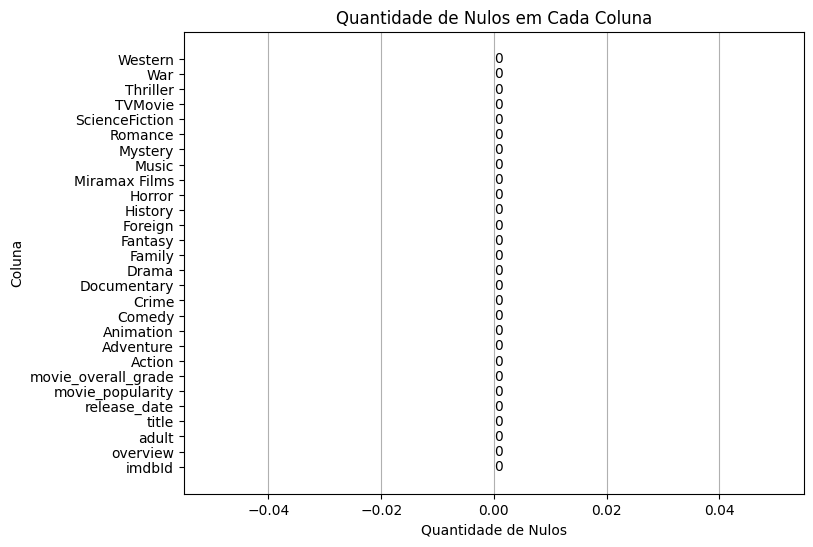

In [ ]:
quantidade_nulos = [df_preprocess_movies.filter(F.col(coluna).isNull()).count() for coluna in df_preprocess_movies.columns]
nomes_colunas = df_preprocess_movies.columns

plt.figure(figsize=(8, 6))
plt.barh(nomes_colunas, quantidade_nulos, color='lightblue')
plt.xlabel('Quantidade de Nulos')
plt.ylabel('Coluna')
plt.title('Quantidade de Nulos em Cada Coluna')
plt.grid(axis='x')

for i in range(len(nomes_colunas)):
    plt.text(quantidade_nulos[i], i, str(quantidade_nulos[i]), va='center')
plt.yticks(np.arange(len(nomes_colunas)), nomes_colunas)
plt.show()

In [ ]:
schema = T.ArrayType(T.StructType([
    T.StructField("cast_id", T.IntegerType(), True),
    T.StructField("character", T.StringType(), True),
    T.StructField("credit_id", T.StringType(), True),
    T.StructField("gender", T.IntegerType(), True),
    T.StructField("id", T.IntegerType(), True),
    T.StructField("name", T.StringType(), True),
    T.StructField("order", T.IntegerType(), True),
    T.StructField("profile_path", T.StringType(), True)
]))

df_exploded = (
    df_credits
    .withColumn("cast", F.from_json("cast", schema))
    .withColumn("cast", F.explode("cast"))
)

df_cast = (
    df_exploded
    .filter(F.col("id").rlike("^\d+$"))
    .select(
        F.col("id").alias("movie_id"),
        F.col("cast.cast_id"),
        F.col("cast.character"),
        F.col("cast.credit_id"),
        F.col("cast.gender"),
        F.col("cast.id").alias("actor_id"),
        F.col("cast.name").alias("actor_name"),
    )
)


In [ ]:
df_cast.show(truncate=False)

+--------+-------+----------------------------+------------------------+------+--------+-------------------------+
|movie_id|cast_id|character                   |credit_id               |gender|actor_id|actor_name               |
+--------+-------+----------------------------+------------------------+------+--------+-------------------------+
|15602   |2      |Max Goldman                 |52fe466a9251416c75077a8d|2     |6837    |Walter Matthau           |
|15602   |3      |John Gustafson              |52fe466a9251416c75077a91|2     |3151    |Jack Lemmon              |
|15602   |4      |Ariel Gustafson             |52fe466a9251416c75077a95|1     |13567   |Ann-Margret              |
|15602   |5      |Maria Sophia Coletta Ragetti|52fe466a9251416c75077a99|1     |16757   |Sophia Loren             |
|15602   |6      |Melanie Gustafson           |52fe466a9251416c75077a9d|1     |589     |Daryl Hannah             |
|15602   |9      |Grandpa Gustafson           |53e5fcc2c3a3684430000d65|2     |1

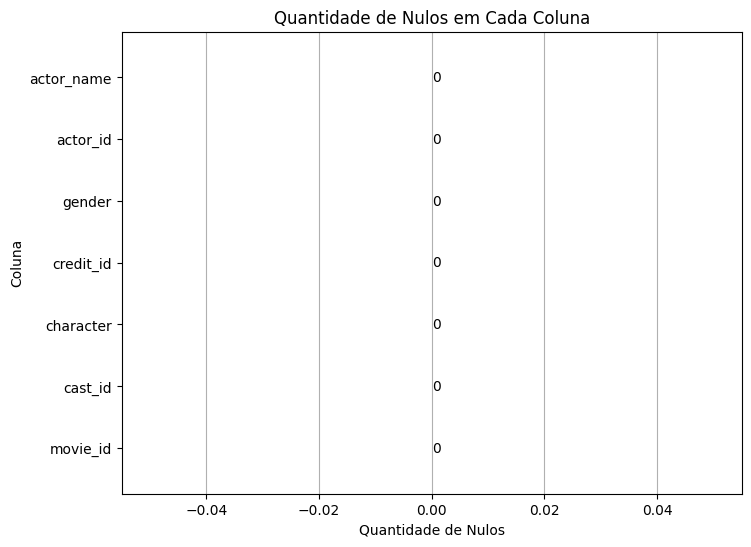

In [ ]:
quantidade_nulos = [df_cast.filter(F.col(coluna).isNull()).count() for coluna in df_cast.columns]
nomes_colunas = df_cast.columns

plt.figure(figsize=(8, 6))
plt.barh(nomes_colunas, quantidade_nulos, color='lightblue')
plt.xlabel('Quantidade de Nulos')
plt.ylabel('Coluna')
plt.title('Quantidade de Nulos em Cada Coluna')
plt.grid(axis='x')

for i in range(len(nomes_colunas)):
    plt.text(quantidade_nulos[i], i, str(quantidade_nulos[i]), va='center')
plt.yticks(np.arange(len(nomes_colunas)), nomes_colunas)
plt.show()


In [ ]:


schema = T.ArrayType(T.StructType([
    T.StructField("id", T.IntegerType(), True),
    T.StructField("name", T.StringType(), True)
]))

df_exploded = (
    df_keywords
    .filter(F.col("id").rlike("^\d+$"))
    .withColumn("keywords", F.from_json("keywords", schema))
    .withColumn("keywords", F.explode("keywords"))
    .withColumn("keyword_name", F.trim(F.col("keywords.name")))
)

window_spec = Window.partitionBy("partition").orderBy(F.desc("count"))
df_keyword_counts = (
    df_exploded
    .groupBy("keyword_name")
    .count()
    .withColumn("partition", F.lit(1))
    .withColumn("keyword_id", F.row_number().over(window_spec))
)

df_keyword_edit = (
    df_exploded
    .join(df_keyword_counts, on="keyword_name", how="inner")
    .select(
        F.col("id").alias("movie_id"),
        F.col("keyword_id"),
        F.col("keyword_name")
    )
)



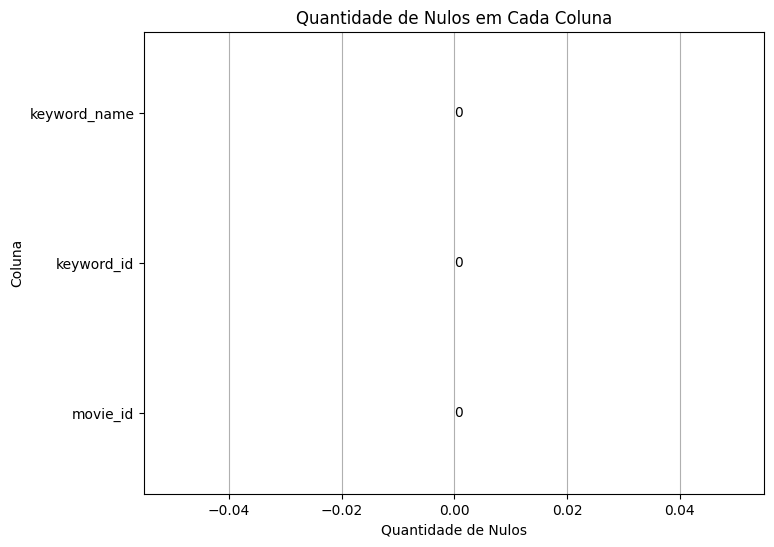

In [ ]:
quantidade_nulos = [df_keyword_edit.filter(F.col(coluna).isNull()).count() for coluna in df_keyword_edit.columns]
nomes_colunas = df_keyword_edit.columns

plt.figure(figsize=(8, 6))
plt.barh(nomes_colunas, quantidade_nulos, color='lightblue')
plt.xlabel('Quantidade de Nulos')
plt.ylabel('Coluna')
plt.title('Quantidade de Nulos em Cada Coluna')
plt.grid(axis='x')

for i in range(len(nomes_colunas)):
    plt.text(quantidade_nulos[i], i, str(quantidade_nulos[i]), va='center')
plt.yticks(np.arange(len(nomes_colunas)), nomes_colunas)
plt.show()

In [ ]:
df_ratings_2 = (
    df_ratings
    .withColumn('rating', F.round((F.col("rating")/5),2))
)

In [ ]:
import pandas as pd
import glob
import os
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
generos = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'ScienceFiction', 'TVMovie', 'Thriller', 'War', 'Western']

def read_parquet(pasta):
    arquivos_parquet = glob.glob(os.path.join(pasta, '*.parquet'))
    lista_df = [pd.read_parquet(arquivo) for arquivo in arquivos_parquet]
    df = pd.concat(lista_df, ignore_index=True)
    return df

In [ ]:
df_parquet = read_parquet('./preprocess/movies')[generos]
label = 'Action'
features = generos.copy()
features.remove(label)


In [ ]:
df_parquet.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,ScienceFiction,TVMovie,Thriller,War,Western
0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

# Aplicar o SelectKBest com o teste qui-quadrado
X = df_parquet[generos]  # features: gêneros dos filmes
y = df_parquet['Action']  # variável alvo: gênero do filme

# Seleção das melhores características
selector = SelectKBest(chi2, k="all")
selector.fit(X, y)

generos_selecionados = selector.get_feature_names_out()
print("Os 5 gêneros mais relevantes são:", generos_selecionados)

[3.25440000e+04 2.86508962e+03 4.75430042e+00 2.48021475e+02
 7.78365630e+02 5.67026428e+02 2.26534444e+02 5.32445216e+01
 6.74390179e+01 3.78370873e+01 8.64672631e+00 8.77939628e+01
 1.74631017e+02 5.17526361e+01 3.75531453e+02 8.61137528e+02
 1.59672440e+01 1.24869990e+03 8.34284511e+01 2.95561759e+02]
            Gênero         Score
0           Action  32544.000000
1        Adventure   2865.089621
2        Animation      4.754300
3           Comedy    248.021475
4            Crime    778.365630
5      Documentary    567.026428
6            Drama    226.534444
7           Family     53.244522
8          Fantasy     67.439018
9          Foreign     37.837087
10         History      8.646726
11          Horror     87.793963
12           Music    174.631017
13         Mystery     51.752636
14         Romance    375.531453
15  ScienceFiction    861.137528
16         TVMovie     15.967244
17        Thriller   1248.699905
18             War     83.428451
19         Western    295.561759


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Exemplo de dataframe com os gêneros (features) e o gênero alvo
X = df_parquet[generos]  # Features: gêneros dos filmes
y = df_parquet['Action']  # Variável alvo: gênero do filme

# Definir e treinar o modelo Random Forest
model = RandomForestClassifier(criterion='entropy',random_state=42)
model.fit(X, y)

# Obter a importância das features
importances = model.feature_importances_

# Criar um dataframe para visualizar as importâncias
importancia_df = pd.DataFrame({'Gênero': generos, 'Importância': importances})

# Ordenar as importâncias do maior para o menor
importancia_ordenada = importancia_df.sort_values(by='Importância', ascending=False)
print(importancia_ordenada)

# Definir um threshold (por exemplo, selecionar importância acima de 0.05)
threshold = 0.005
generos_selecionados = importancia_ordenada[importancia_ordenada['Importância'] > threshold]

# Gêneros selecionados
print("Gêneros selecionados com base no threshold:")
print(generos_selecionados)


            Gênero  Importância
0           Action     0.909201
1        Adventure     0.026766
17        Thriller     0.014192
5      Documentary     0.010750
15  ScienceFiction     0.006442
4            Crime     0.006186
6            Drama     0.004466
14         Romance     0.003777
11          Horror     0.003685
3           Comedy     0.003026
19         Western     0.002482
13         Mystery     0.002393
7           Family     0.001906
12           Music     0.001009
2        Animation     0.000900
18             War     0.000847
8          Fantasy     0.000703
9          Foreign     0.000579
16         TVMovie     0.000349
10         History     0.000342
Gêneros selecionados com base no threshold:
            Gênero  Importância
0           Action     0.909201
1        Adventure     0.026766
17        Thriller     0.014192
5      Documentary     0.010750
15  ScienceFiction     0.006442
4            Crime     0.006186


In [ ]:
print(model.criterion)

entropy
